based on 
https://github.com/nicknochnack/StreetFighterRL/blob/main/StreetFighter-Tutorial.ipynb

In [1]:
import gym
import retro
import time
import numpy as np

from gym import Env
from gym.spaces import MultiBinary, Box
import cv2

from matplotlib import pyplot as plt

# Importing the optimzation frame - HPO
import optuna
# PPO algo for RL
from stable_baselines3 import PPO
# Bring in the eval policy method for metric calculation
from stable_baselines3.common.evaluation import evaluate_policy
# Import the sb3 monitor for logging 
from stable_baselines3.common.monitor import Monitor
# Import the vec wrappers to vectorize and frame stack
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
# Import os to deal with filepaths
import os

from stable_baselines3.common.callbacks import BaseCallback

In [17]:
#retro.data.list_games()

#!pip install gym gym-retro
#!pip install opencv-python

# download ROM and unpack to roms/
# https://wowroms.com/en/roms/sega-genesis-megadrive/download-street-fighter-ii-special-champion-edition-europe/26496.html

# import from /roms location
# python -m retro.import .

In [35]:
# test preprocessing steps

# plt.imshow(obs)
# gray = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
# # Resize 
# resize = cv2.resize(gray, (84,84), interpolation=cv2.INTER_CUBIC)
#         # Add the channels value
# channels = np.reshape(resize, (84,84,1))
#plt.imshow(cv2.cvtColor(channels, cv2.COLOR_BGR2RGB))

In [36]:
info

{'enemy_matches_won': 0,
 'score': 0,
 'matches_won': 0,
 'continuetimer': 0,
 'enemy_health': 169,
 'health': 176}

In [21]:
env = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis')
#env = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis', use_restricted_actions=retro.Actions.FILTERED)

In [12]:
# close if alredy running or gym retrowrapper
env.close()

In [15]:
print(env.observation_space.shape)
print(env.action_space)

(200, 256, 3)
MultiBinary(12)


In [24]:
obs = env.reset()
done = False
for game in range(1):
    while not done:
        if done:
            obs = env.reset()
        env.render()        
        obs, reward, done, info = env.step(env.action_space.sample())
        time.sleep(0.01)
        #print(reward)            

KeyboardInterrupt: 

In [2]:
class StreetFighter(Env):
    def __init__(self):
        super().__init__()
        #self.observation_space = Box(low=0, high=255, shape=(200,256,3), dtype=np.uint8)
        self.observation_space = Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)
        self.action_space = MultiBinary(12)
        self.game = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis', use_restricted_actions=retro.Actions.FILTERED)        

    def step(self, action):
        # Take a step 
        obs, reward, done, info = self.game.step(action)
        obs = self.preprocess(obs) 
        
        # Frame delta 
        frame_delta = obs #- self.previous_frame
        #self.previous_frame = obs 
        
        # Reshape the reward function
        reward = info['score'] - self.score 
        self.score = info['score'] 
        
        return frame_delta, reward, done, info
    
    def render(self, *args, **kwargs):
        self.game.render()
    
    def close(self):
        self.game.close()
    
    def reset(self):
        self.previous_frame = np.zeros(self.game.observation_space.shape)
        # Return the first frame 
        obs = self.game.reset()
        obs = self.preprocess(obs) 
        self.previous_frame = obs 
        
        # Create a attribute to hold the score delta 
        self.score = 0 
        return obs
    def preprocess(self, observation):
        # Grayscaling 
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        # Resize 
        resize = cv2.resize(gray, (84,84), interpolation=cv2.INTER_CUBIC)
        # Add the channels value
        channels = np.reshape(resize, (84,84,1))
        return channels         

In [3]:
env = StreetFighter()

In [ ]:
env.observation_space
env.action_space
env.reset()

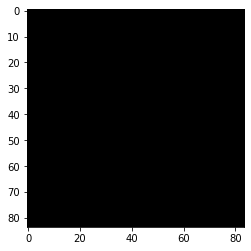

In [66]:
# try this out a few times to see what agent is seeing
obs, reward, done, info = env.step(env.action_space.sample())
plt.imshow(cv2.cvtColor(obs, cv2.COLOR_BGR2RGB))

In [8]:
# env = StreetFighter()

# obs = env.reset()
# done = False
# for game in range(1): 
#     while not done: 
#         if done: 
#             obs = env.reset()
#         env.render()
#         action = model.predict(obs)[0]
#         obs, reward, done, info = env.step(action)
#         time.sleep(0.01)
#         if reward > 0:            
#             print(reward)

128.0

In [3]:
LOG_DIR = './logs/'
OPT_DIR = './opt/'

# Function to return test hyperparameters - define the object function
def optimize_ppo(trial): 
    return {
        'n_steps':trial.suggest_int('n_steps', 2048, 8192, step=64),
        'gamma':trial.suggest_loguniform('gamma', 0.8, 0.9999),
        'learning_rate':trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
        'clip_range':trial.suggest_uniform('clip_range', 0.1, 0.4),
        'gae_lambda':trial.suggest_uniform('gae_lambda', 0.8, 0.99)
    }

SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(1))

In [4]:
# Run a training loop and return mean reward 
def optimize_agent(trial):
    try:
        model_params = optimize_ppo(trial) 

        # Create environment 
        env = StreetFighter()
        env = Monitor(env, LOG_DIR)
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env, 4, channels_order='last')

        # Create algo 
        model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=0, **model_params)
        #model.learn(total_timesteps=30000)
        model.learn(total_timesteps=100000)

        # Evaluate model 
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=20)
        env.close()

        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)

        return mean_reward

    except Exception as e:
        return -1000

In [5]:
# Creating the experiment 
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent, n_trials=100, n_jobs=1)

[I 2022-05-10 10:06:18,822] A new study created in memory with name: no-name-c90272a0-e57d-4649-9443-7eb8f764ca4c
[I 2022-05-10 10:15:19,757] Trial 0 finished with value: 2000.0 and parameters: {'n_steps': 8192, 'gamma': 0.9417055931401845, 'learning_rate': 2.4262227261296617e-05, 'clip_range': 0.1722336986060597, 'gae_lambda': 0.8123529719441188}. Best is trial 0 with value: 2000.0.
[I 2022-05-10 10:24:17,448] Trial 1 finished with value: 2500.0 and parameters: {'n_steps': 7936, 'gamma': 0.8578766664804056, 'learning_rate': 9.892467437048821e-05, 'clip_range': 0.2753600202652925, 'gae_lambda': 0.8335063812663515}. Best is trial 1 with value: 2500.0.
[I 2022-05-10 10:31:54,471] Trial 2 finished with value: 100.0 and parameters: {'n_steps': 3712, 'gamma': 0.8437412833181335, 'learning_rate': 9.249440195539925e-05, 'clip_range': 0.3769206017018909, 'gae_lambda': 0.8911954060591915}. Best is trial 1 with value: 2500.0.
[I 2022-05-10 10:40:26,907] Trial 3 finished with value: 2000.0 and pa

In [6]:
study.best_trial

FrozenTrial(number=70, values=[18800.0], datetime_start=datetime.datetime(2022, 5, 10, 20, 26, 29, 732815), datetime_complete=datetime.datetime(2022, 5, 10, 20, 35, 55, 431298), params={'n_steps': 8064, 'gamma': 0.8167612002780619, 'learning_rate': 2.5921942692780992e-05, 'clip_range': 0.31672907531020905, 'gae_lambda': 0.8667916462640943}, distributions={'n_steps': IntUniformDistribution(high=8192, low=2048, step=64), 'gamma': LogUniformDistribution(high=0.9999, low=0.8), 'learning_rate': LogUniformDistribution(high=0.0001, low=1e-05), 'clip_range': UniformDistribution(high=0.4, low=0.1), 'gae_lambda': UniformDistribution(high=0.99, low=0.8)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=70, state=TrialState.COMPLETE, value=None)

In [7]:
study.best_params

{'n_steps': 8064,
 'gamma': 0.8167612002780619,
 'learning_rate': 2.5921942692780992e-05,
 'clip_range': 0.31672907531020905,
 'gae_lambda': 0.8667916462640943}

In [8]:
nickparams = {
        'n_steps': 7488,
        'gamma': 0.9,
        'learning_rate': 3e-07,
        'clip_range': 0.39,
        'gae_lambda': 0.84}

no_diff_params = {'n_steps': 8064,
 'gamma': 0.8167612002780619,
 'learning_rate': 2.5921942692780992e-05 * 0.01,
 'clip_range': 0.31672907531020905,
 'gae_lambda': 0.8667916462640943}

#model = PPO.load(os.path.join(OPT_DIR, 'trial_4_best_model.zip'))
#model = PPO.load(os.path.join(OPT_DIR, 'trial_71_best_model.zip'))

In [9]:
CHECKPOINT_DIR = './train/'

class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [10]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [11]:
env = StreetFighter()
env = Monitor(env, LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [10]:
model_params = {'n_steps': 5760,
                 'gamma': 0.62 + 0.1,
                 'learning_rate': 3e-05 * 0.01,
                 'clip_range': 0.16,
                 'gae_lambda': 0.896}
model_params

{'n_steps': 5760,
 'gamma': 0.72,
 'learning_rate': 3.0000000000000004e-07,
 'clip_range': 0.16,
 'gae_lambda': 0.896}

In [12]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, **no_diff_params)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [13]:
#model.load(os.path.join(OPT_DIR, 'best_model_4500000.zip'))
model.load(os.path.join(OPT_DIR, 'trial_70_best_model.zip'))
#trial_4_best_model
#model.load('./train/PPO_500k.dat')
model.gae_lambda

0.8667916462640943

In [14]:
# run from root dir or logs dir
# tensorboard --logdir=.a

2.592194269278099e-07

In [15]:
model.learn(total_timesteps=5000000, callback=callback)

Logging to ./logs/PPO_208
-----------------------------
| time/              |      |
|    fps             | 470  |
|    iterations      | 1    |
|    time_elapsed    | 17   |
|    total_timesteps | 8064 |
-----------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.2e+04       |
|    ep_rew_mean          | 2.97e+04      |
| time/                   |               |
|    fps                  | 360           |
|    iterations           | 2             |
|    time_elapsed         | 44            |
|    total_timesteps      | 16128         |
| train/                  |               |
|    approx_kl            | 1.5682068e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.317         |
|    entropy_loss         | -8.32         |
|    explained_variance   | 1.78e-05      |
|    learning_rate        | 2.59e-07      |
|    loss                 | 245           |
|    n_updates  

In [17]:
#model.save('./train/PPO_500k.dat')

In [16]:
#model = PPO.load('./train/best_model_4500000.zip')
#model = PPO.load('./best_model_5460000.zip')
mean_reward, _ = evaluate_policy(model, env, render=True, n_eval_episodes=1)
mean_reward

2000.0

In [16]:
env.close()

In [17]:
# Reset game to starting state
obs = env.reset()
# Set flag to flase
done = False
for game in range(1): 
    while not done: 
        if done: 
            obs = env.reset()
        env.render()
        action = model.predict(obs)[0]
        obs, reward, done, info = env.step(action)
        time.sleep(0.01)
        #if reward > 0:
        #    print(reward)